In [17]:
from __future__ import division
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Problem 1 

In [18]:
import kplr
client = kplr.API()
koi = client.koi(97.01)
lcs = koi.get_light_curves(short_cadence=False)
f = lcs[0].open()
hdu_data = f[1].data
time = hdu_data["time"]
flux = hdu_data["sap_flux"]
flux_err = hdu_data["sap_flux_err"]
f.close()

In [19]:
# obtain indices of light-curve points within specified time window
indices = np.where((time >= 124)&(time <= 125))

In [20]:
# assign flux, time, and uncertainty values associated obtained indices
time125 = time[indices[0][0]:indices[0][-1]]
flux125 = flux[indices[0][0]:indices[0][-1]]
sig125 = flux_err[indices[0][0]:indices[0][-1]]

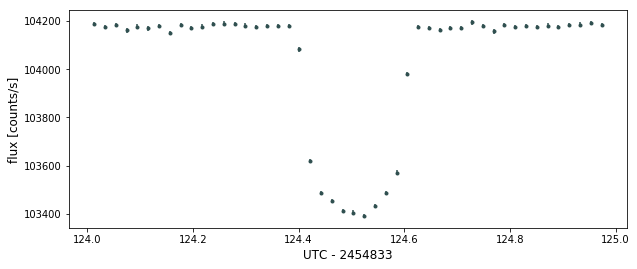

In [21]:
# plot the light-curve (for visualization purposes)
plt.figure(figsize=(10,4))
plt.errorbar(time125, flux125, sig125, color='darkslategrey', marker='.', ls='None')
plt.xlabel('UTC - 2454833', fontsize=12)
plt.ylabel('flux [counts/s]', fontsize=12)
plt.show()

In [22]:
# function to normalize stellar flux
def normstar(flux):
    """ returns the mean unobscured stellar flux, excluding the transit; 
        transit is excluded by calculating the mean and standard deviation
        of the light curve and removing the points which lie more than 2sigma 
        away from the mean"""
    fvals = []
    Fbar = np.mean(flux)
    sigma = np.std(flux)
    for f in flux:
        if abs(f - Fbar)/sigma > 2.0:
            continue
        else:
            fvals.append(f)
    
    return np.mean(fvals), fvals

In [23]:
# calculating the mean unobscured stellar flux and normalize light-curve
flux4mean = flux125
for i in range(5):
    meanflux, flux4mean = normstar(flux4mean)

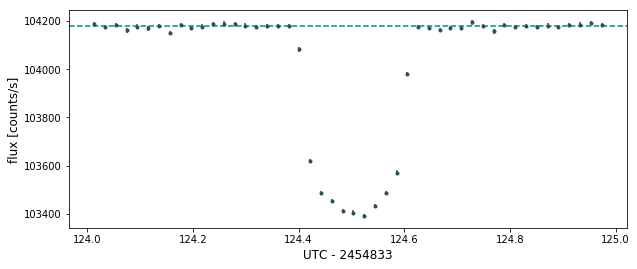

In [24]:
# plot the light-curve with mean stellar flux
plt.figure(figsize=(10,4))
plt.errorbar(time125, flux125, sig125, color='darkslategrey', marker='.', ls='None')
plt.axhline(y=meanflux, color='darkcyan', ls='--')
plt.xlabel('UTC - 2454833', fontsize=12)
plt.ylabel('flux [counts/s]', fontsize=12)
plt.show()

In [25]:
# normalize light-curve and uncertainties
flux_norm = flux125/meanflux
sig_norm = sig125/meanflux

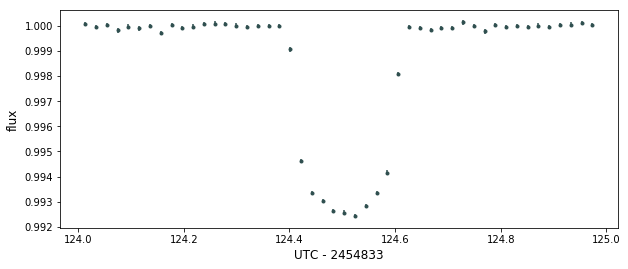

In [26]:
# plot the normalized light-curve
plt.figure(figsize=(10,4))
plt.errorbar(time125, flux_norm, sig_norm, color='darkslategrey', marker='.', ls='None')
plt.xlabel('UTC - 2454833', fontsize=12)
plt.ylabel('flux', fontsize=12)
plt.show()

##### limb-darkening relation: $I(r) = 1-(1-\mu^{1/2})$; where $\mu = (1-r^2)^{1/2}$

In [27]:
# define limb-darkening function
def I_r(r):
    mu = np.sqrt(1 - r**2)
    return 1 - (1 - np.sqrt(mu))

In [28]:
# guesses for parameters and conversion of time to 'z'
p = 0.0775
tau = 0.1
t0 = 124.51

z_vals = (time125 - t0) / tau

In [29]:
# define 'del' function for flux ratio calculation
def delta(r, p, z):
    z = abs(z)
    if (z+p <= r) or (r <= z-p):
        d = 0
    elif r+z <= p:
        d = 1
    else:
        if (z != 0) and (r != 0):
            d = (1/np.pi) * np.arccos((z**2 - p**2 + r**2) / (2*z*r))
        else:
            print "WARNING! Either 'r' or 'z' have vanished; cannot divide by zero!"
    return d

In [30]:
numerator = lambda r: I_r(r) * (1 - delta(r, p, z)) * 2*r
denominator = lambda r: I_r(r) * 2*r

In [51]:
# using scipy integrate to ...
bottom_test = []
f_vals = np.zeros(len(z_vals))
for i in range(len(z_vals)):
    z = z_vals[i]
    top = integrate.quad(numerator, 0, 1)
    bottom = integrate.quad(denominator, 0, 1)
    bottom_test.append(bottom[0])
    f_vals[i] = top[0]/bottom[0]

In [32]:
# define chi-squared function
def chi2(f_model, f_obs, sig_obs):
    """ returns the chi-squared value  """
    return sum(((f_obs - f_model)/sig_obs)**2)

In [33]:
# calculate the chi-squared value for the fitted limb-darkening model
X2 = chi2(f_vals, flux_norm, sig_norm)

In [34]:
# print calculated chi-squared value
print u'\u03C7\u00B2=', X2

χ²= 464.862918399


### Problem 2

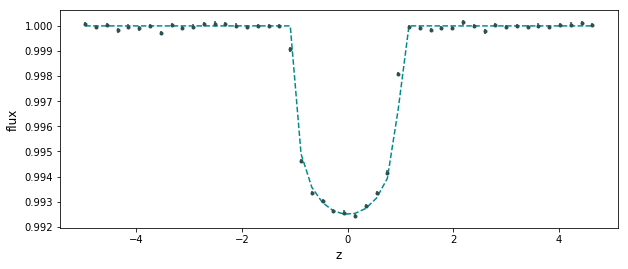

In [35]:
# plot the normalized light-curve with the fitted limb-darkening model
plt.figure(figsize=(10,4))
plt.errorbar(z_vals, flux_norm, sig_norm, color='darkslategrey', marker='.', ls='None')
plt.plot(z_vals, f_vals, color='darkcyan', ls='--')
plt.xlabel('z', fontsize=12)
plt.ylabel('flux', fontsize=12)
plt.show()

#### Bye 'eye', this appears to be a good fit

In [36]:
N = len(z_vals)
M = 3
nu = N-M

a = nu/2
x = X2/2

In [37]:
gamma = lambda t: np.exp(-t) * t**(a-1)

In [38]:
top = integrate.quad(gamma, x, np.inf)
bottom = integrate.quad(gamma, 0, np.inf)

Q = top[0] / bottom[0]

In [39]:
print "Q =", Q

Q = 3.94910224032e-71


Very small Q; meaning the fitted model is probably wrong...
Not a good fit

### Problem 3

In [40]:
start = 0.08
finish = 0.13
ds = 0.0010
cf = 1/ds
tau_vals = np.arange(start*cf, (finish+ds)*cf, ds*cf)/cf

In [41]:
chi2_vals = []
for tau_val in tau_vals:
    z_vals = (time125 - t0) / tau_val
    f_vals = np.zeros(len(z_vals))
    for i in range(len(z_vals)):
        z = z_vals[i]
        top = integrate.quad(numerator, 0, 1)
        bottom = integrate.quad(denominator, 0, 1)
        f_vals[i] = top[0]/bottom[0]
    X2 = chi2(f_vals, flux_norm, sig_norm)
    chi2_vals.append(X2)

In [42]:
# find index for minimum chi-squared value
chi2_min = np.argmin(chi2_vals)

In [43]:
print chi2_vals[chi2_min]
print tau_vals[chi2_min]

247.868901725
0.097


In [44]:
# exploring new tau-value
new_tau = tau_vals[chi2_min]
new_zvals = (time125 - t0) / new_tau

new_fvals = np.zeros(len(new_zvals))
for i in range(len(new_zvals)):
    z = new_zvals[i]
    top = integrate.quad(numerator, 0, 1)
    bottom = integrate.quad(denominator, 0, 1)
    new_fvals[i] = top[0]/bottom[0]

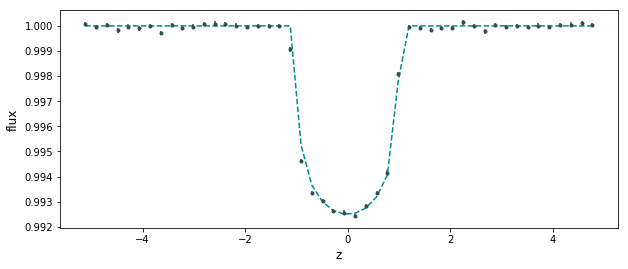

In [45]:
# plot the normalized light-curve with the fitted limb-darkening model
plt.figure(figsize=(10,4))
plt.errorbar(new_zvals, flux_norm, sig_norm, color='darkslategrey', marker='.', ls='None')
plt.plot(new_zvals, new_fvals, color='darkcyan', ls='--')
plt.xlabel('z', fontsize=12)
plt.ylabel('flux', fontsize=12)
plt.show()

In [46]:
N = len(z_vals)
M = 3
nu = N-M

a = nu/2
x = chi2_vals[chi2_min]/2

In [47]:
top = integrate.quad(gamma, x, np.inf)
bottom = integrate.quad(gamma, 0, np.inf)

Q = top[0] / bottom[0]

In [48]:
print "Q =", Q

Q = 7.66249916787e-30


In [49]:
start = 0.09670
finish = 0.09715
ds = 0.00001
cf = 1/ds
tau_vals = np.arange(start*cf, (finish+ds)*cf, ds*cf)/cf

In [50]:
chi2_vals = []
for tau_val in tau_vals:
    z_vals = (time125 - t0) / tau_val
    f_vals = np.zeros(len(z_vals))
    for i in range(len(z_vals)):
        z = z_vals[i]
        top = integrate.quad(numerator, 0, 1)
        bottom = integrate.quad(denominator, 0, 1)
        f_vals[i] = top[0]/bottom[0]
    X2 = chi2(f_vals, flux_norm, sig_norm)
    chi2_vals.append(X2)

In [131]:
# find index for minimum chi-squared value
chi2_min = np.argmin(chi2_vals)

Still a pretty crappy p-value...

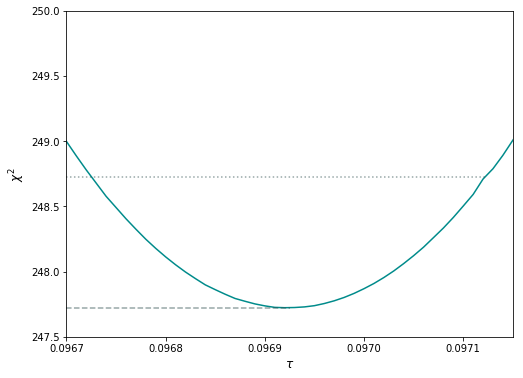

In [132]:
plt.figure(figsize=(8,6))
plt.plot(tau_vals, chi2_vals, color='darkcyan', ls='-')
plt.axhline(y=chi2_vals[chi2_min]+1, xmax=0.94, color='darkslategrey', ls=':', alpha=0.5)
plt.axhline(y=chi2_vals[chi2_min], xmax=0.5, color='darkslategrey', ls='--', alpha=0.5)
plt.xlim([0.09670, 0.09715])
plt.ylim([247.5, 250])
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'$\chi^2$', fontsize=12)
plt.show()

In [133]:
print chi2_vals[chi2_min]
print tau_vals[chi2_min]

247.72302829
0.09692


### Problem 4

In [10]:
def lnprior(x):
    """ Return the log prior given parameter vector 'x' """
    p, tau, t0 = x
    if p < 0.05 or p > 0.15:
        return -np.inf
    elif tau < 0.08 or tau > 0.13:
        return -np.inf
    elif t0 < 124.4 or tau > 124.6:
        return -np.inf
    else:
        return 0

In [ ]:
def log_likelihood(x, t, flux, sigma):
    p, tau, t0 = x
    

In [ ]:
def lnlike(x, model):
    """ Return the log likelihood given parameter vector 'x' """
    ll = lnprior(x)
    if np.isinf(ll):
        return ll, (np.nan, np.nan)
    p, tau, t0 = x
    